In [1]:
%cd ..
%pwd

/home/guilherme/scantensus-sdy


/home/guilherme/.ai-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/guilherme/scantensus-sdy'

In [2]:
from pathlib import Path

from src.utils.matt_heatmap import UnityMakeHeatmaps
from src.pressure_damping.pretransformations import PretransformationsModule
from src.pressure_damping.curve_dataset import CurveDataset

import numpy as np
import torch
import torchvision

from matplotlib import cm
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive

import PIL
import PIL.Image

IMAGE_SHAPE = (512, 512)

dataset = CurveDataset(
    projects=['imp-coro-shunshin-sdy-flow-good'],
    output_shape=IMAGE_SHAPE,
    firebase_certificate=Path('.firebase.json')
)

2024-01-20 17:35:17.178 | INFO     | src.pressure_damping.curve_dataset:__init__:110 - Loaded 1 results containing 90 curves.


In [3]:
res = dataset[0]

image = res['image']
T = res['transform_matrix']
width_shift = res['width_shift']
height_shift = res['height_shift']
labels = res['labels']

image.shape

/home/guilherme/scantensus-sdy/src/pressure_damping/curve_dataset.py:190: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1508.)
  img_bytes = torch.frombuffer(r.content, dtype=torch.uint8)
2024-01-20 17:35:17.189 | DEBUG    | src.pressure_damping.curve_dataset:read_image_into_t:193 - http://cardiac5.ts.zomirion.com:50601/scantensus-database-png-flat/01/03/9a/01-039a5b730e6fa2320f23fa1518b15107329b3d83c011aeaaae44ae35eadfb29c-0004.png: Successfully loaded


torch.Size([1, 512, 512])

In [4]:
def plot_image_with_heatmap(index: int):
    res = dataset[index]

    image = res['image']
    T = res['transform_matrix']
    width_shift = res['width_shift']
    height_shift = res['height_shift']
    raw_labels = res['labels']

    heatmap_gen = UnityMakeHeatmaps(
        keypoint_names=['curve-flow'],
        image_crop_size=(dataset.crop_shape[0], dataset.crop_shape[1]),
        image_out_size=(dataset.output_shape[0], dataset.output_shape[1]),
    )

    heatmaps, weights = heatmap_gen.forward(
        label_data=[raw_labels],
        label_height_shift=[height_shift],
        label_width_shift=[width_shift],
        transform_matrix=[T]
    )

    # rendering stuff

    heatmap = heatmaps[0].squeeze()
    jet_map = cm.get_cmap('jet')

    heatmap_jetted = PIL.Image.fromarray((jet_map(heatmap.numpy()) * 255).astype(np.uint8))

    SHOW_H = dataset.output_shape[0] // 1
    SHOW_W = dataset.output_shape[1] // 1

    resized_heatmap = torchvision.transforms.Resize((SHOW_H, SHOW_W))(heatmap_jetted)
    original_image = torchvision.transforms.Resize((SHOW_H, SHOW_W))(torchvision.transforms.ToPILImage()(image))

    resized_heatmap = resized_heatmap.convert('RGBA')
    original_image = original_image.convert('RGBA')

    blended = PIL.Image.blend(original_image, resized_heatmap, alpha=0.2)

    return blended

plot_image_with_heatmap(89)

2024-01-18 12:34:15.950 | DEBUG    | src.pressure_damping.curve_dataset:read_image_into_t:193 - http://cardiac5.ts.zomirion.com:50601/scantensus-database-png-flat/01/ff/6a/01-ff6a5728598c8b59b910cf7d329beeb7629f4fb36d809787c8feab9e950437c4-0157.png: Successfully loaded


RuntimeError: grid_sampler_2d_cpu not implemented for Byte

In [9]:
def new_plot_image_with_heatmap(index: int):
    image, raw_labels, T = dataset[index]

    pretransform = PretransformationsModule(
        keypoint_names=['curve-flow'],
        image_crop_size=IMAGE_SHAPE,
        image_out_size=IMAGE_SHAPE
    )

    images, heatmaps, weights = pretransform.forward(
        label_data=[raw_labels],
        images=image.unsqueeze(0),
        dataset_transform_matrices=[T]
    )

    heatmap = heatmaps[0].squeeze()
    jet_map = cm.get_cmap('jet')

    heatmap_jetted = PIL.Image.fromarray((jet_map(heatmap.numpy()) * 255).astype(np.uint8)).convert('RGBA')
    heatmap_jetted = heatmap_jetted.resize((IMAGE_SHAPE[1], IMAGE_SHAPE[0]))

    image = torchvision.transforms.ToPILImage()(images.to(torch.uint8).squeeze()).convert('RGBA')

    return image, heatmap_jetted

image, heatmap = new_plot_image_with_heatmap(0)

2024-01-18 12:24:55.012 | DEBUG    | src.pressure_damping.curve_dataset:read_image_into_t:193 - http://cardiac5.ts.zomirion.com:50601/scantensus-database-png-flat/01/03/9a/01-039a5b730e6fa2320f23fa1518b15107329b3d83c011aeaaae44ae35eadfb29c-0004.png: Successfully loaded


ValueError: too many values to unpack (expected 3)

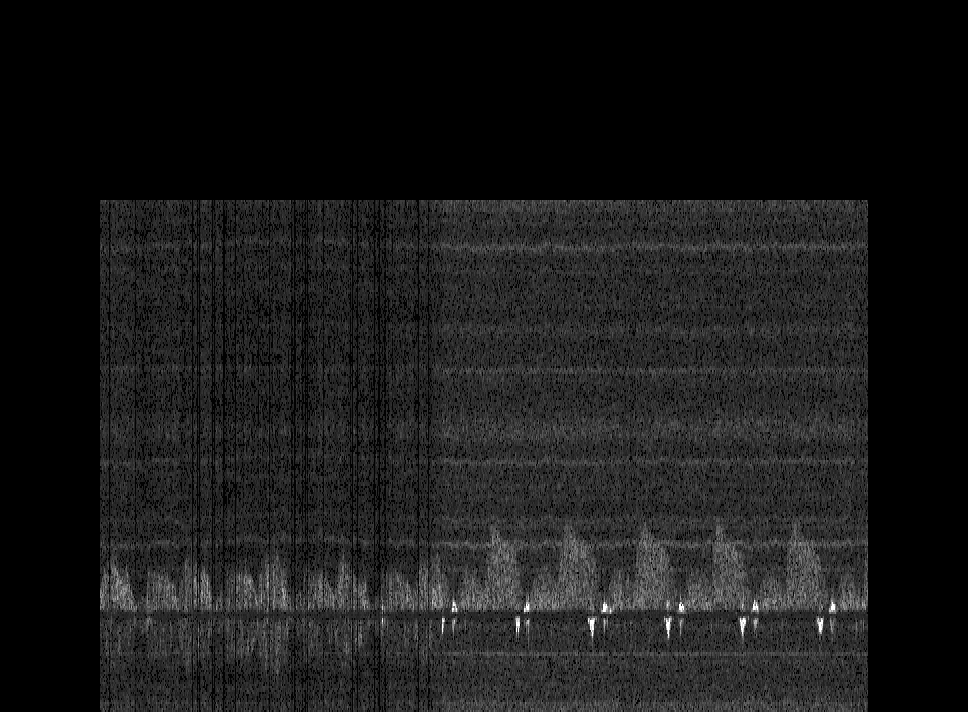

In [7]:
#PIL.Image.blend(image, heatmap, alpha=0.5)
image

# Kornia Transforms

In [70]:
from kornia.geometry.transform import get_affine_matrix2d, warp_affine, warp_perspective, homography_warp, center_crop

In [29]:
def identity_transform(batch_size: int) -> torch.Tensor:
    translations = torch.zeros(batch_size, 2)
    center = torch.tensor([IMAGE_SHAPE[0] / 2, IMAGE_SHAPE[1] / 2]).repeat(batch_size, 1)
    scale = torch.tensor([1.0, 1.0]).repeat(batch_size, 1)
    angle = torch.tensor([0.0]).repeat(batch_size)

    return get_affine_matrix2d(
        translations=translations,
        center=center,
        scale=scale,
        angle=angle
    )


def random_transform_with_fixed_scaling(
        image: torch.Tensor,
        translation_range: tuple[float] = (-0.1, 0.1),
        rotation_range: tuple[float] = (-5, 5),
        scale: tuple[float] = (1.0, 1.0)
        ) -> torch.Tensor:
    """
    Generates a random affine transformation matrix for a given image with a fixed scaling factor.

    :param image: The image to generate the transformation matrix for.
    :param translation_range: The range of the translation in pixels.
    :param rotation_range: The range of the rotation in degrees.
    :param scale: The tuple containing the (x, y) scale of the image.
    :return: The transformation matrix.
    """
    if image.dim() == 3:
        (B, H, W) = image.shape
    elif image.dim() == 4:
        (B, C, H, W) = image.shape
    else:
        raise ValueError(f'Image has invalid shape: {image.shape}')


    translations = torch.distributions.Uniform(*translation_range).sample((B, 2))
    center = torch.tensor([H / 2, W / 2]).repeat(B, 1)
    angle = torch.distributions.Uniform(*rotation_range).sample((B,))
    scale = torch.tensor(scale).repeat(B, 1)

    return get_affine_matrix2d(
        translations=translations,
        center=center,
        scale=scale,
        angle=angle
    )

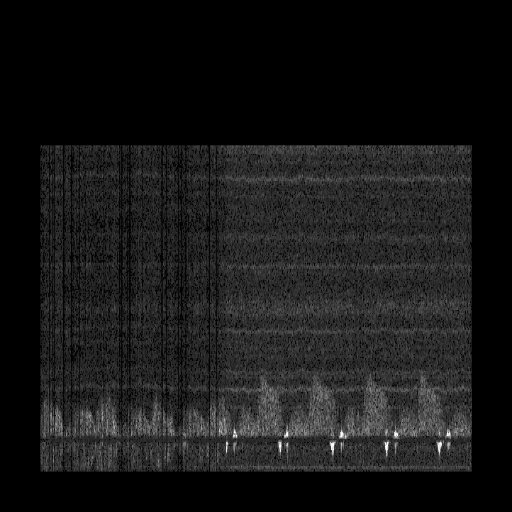

In [30]:
def render_torch_image(image: torch.Tensor) -> PIL.Image:
    return torchvision.transforms.ToPILImage()(image.to(torch.uint8).squeeze()).convert('RGBA')

render_torch_image(image)

torch.Size([1, 1, 512, 512])


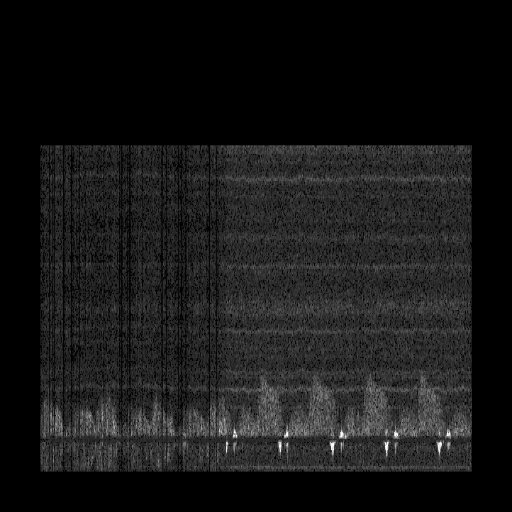

In [31]:
# this adds C dimension to the image
image_expanded = image.to(torch.float32).unsqueeze(1)

print(image_expanded.shape)
render_torch_image(image_expanded)

In [68]:
out_size = (512, 512)
transform_matrix = random_transform_with_fixed_scaling(image_expanded, scale=(0.5, 0.5))

transform_matrix.shape

torch.Size([1, 3, 3])

torch.Size([1, 1, 512, 512]) torch.float32


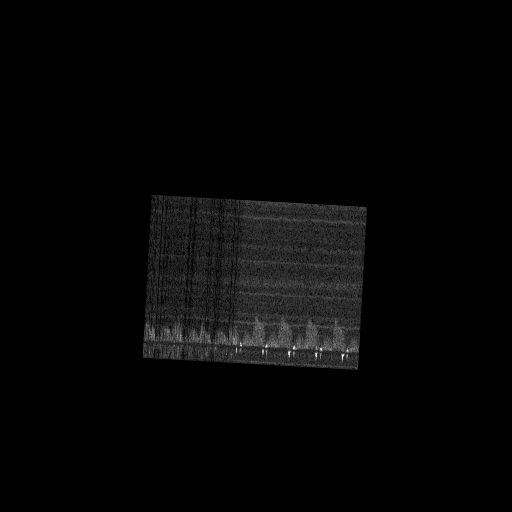

In [69]:
transformed = warp_perspective(image_expanded, transform_matrix, 
                               dsize=out_size, align_corners=True)

print(transformed.shape, transformed.dtype)
render_torch_image(transformed.squeeze(1))

torch.Size([1, 1, 256, 256]) torch.float32


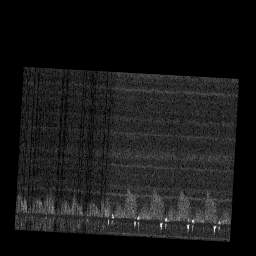

In [72]:
cropped = center_crop(transformed, (256, 256))
print(cropped.shape, cropped.dtype)

render_torch_image(cropped.squeeze(1))

torch.Size([1, 1, 408, 408]) torch.float32
shift: 104, 104


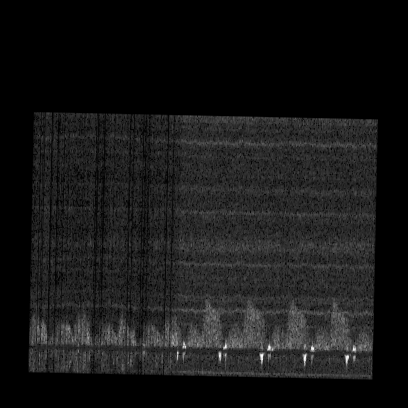

In [82]:
def preprocess_image(image: torch.Tensor, output_size: tuple[float, float]) -> tuple[torch.Tensor, torch.Tensor, tuple[float, float]]:
    """
    Preprocesses an image by applying a random affine transformation and cropping it to the given output size.

    :param image: The image to preprocess.
    :param output_size: The size of the output image.
    :return: The preprocessed image, the transformation matrix and a tuple containing the (height, width) shifts.
    """

    if image.dim() == 3:
        (B, H_in, W_in) = image.shape
    elif image.dim() == 4:
        (B, C, H_in, W_in) = image.shape
    
    H_out, W_out = output_size

    if H_out > H_in or W_out > W_in:
        raise ValueError(f'Output size ({H_out}, {W_out}) must be smaller than input size ({H_in}, {W_in})')

    scaling_factor = (H_out / H_in, W_out / W_in)

    transform_matrix = random_transform_with_fixed_scaling(image, scale=scaling_factor)
    transformed = warp_perspective(image, transform_matrix, dsize=(H_in, W_in), align_corners=True)

    cropped = center_crop(transformed, (H_out, W_out))

    height_shift = H_in - H_out
    width_shift = W_in - W_out

    return cropped, transform_matrix, (height_shift, width_shift)

cropped, transform_matrix, (height_shift, width_shift) = preprocess_image(image_expanded, (408, 408))

print(cropped.shape, cropped.dtype)
print(f"shift: {height_shift}, {width_shift}")

render_torch_image(cropped.squeeze(1))

{'curve-flow': [{'x': [104.04,
    111.48,
    120.21,
    128.94,
    137.93,
    146.55,
    148.66,
    164.23,
    173.29,
    176.19,
    185.26,
    198.48,
    207.36,
    218.39,
    228.15,
    239.07,
    249.99,
    260.95,
    265.35,
    278.24,
    284.6,
    293.05,
    305.73,
    306.65,
    320.15,
    334.74,
    341.33,
    351.75,
    366.53,
    368.28,
    380.46,
    382.79,
    384.02,
    395.24,
    406.46,
    414.76,
    418.48,
    422.19,
    432.82,
    443.44,
    452.83,
    462.37,
    474.54,
    487.79,
    489.3,
    489.8,
    493.12,
    505.95,
    515.51,
    526.2,
    543.47,
    556.25,
    561.39,
    567.79,
    580.8,
    593.8,
    600.1,
    616.01,
    635.63,
    636.14,
    640.8,
    645.45,
    655.68,
    673.52,
    683.44,
    697.05,
    711.54,
    714.9,
    717.76,
    729.81,
    741.86,
    750.27,
    767.56,
    783.64,
    789.23,
    794.87,
    809.2,
    819.44,
    833.64,
    844.23,
    864.92],
   'y': [577.43,
 